# Import

In [1]:
import numpy as np
import pandas as pd
import json
import champ_dataset
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import tensorflow_datasets as tfds
from datasets import load_dataset

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load Champ_dataset

In [2]:
# =================================Load the dataset==================================
# dataset is a champ_dataset.Dataset instance; 'v0' is the dataset used in the paper
dataset = champ_dataset.load('v0')

In [3]:
# =====================Get a random problem and read its content=====================
# get a random problem; dataset.problems is a dictionary
problem_id = random.choice(list(dataset.problems.keys()))
# shortcut for dataset.problems[problem_id]
problem = dataset[problem_id]
# problem identifier (which is equal to problem_id) and problem statement
print(f'{problem.identifier}: {problem.text}')

P_Polynomial_2: Solve the equation x^4+a^4-3a*x^3+3a^3*x=0 for a≠0 as an expression of a.


In [4]:
# iterate over the list of relevant concepts and hints
for ch_id in problem.ch_list:
    ch = dataset[ch_id]  # ch is either a champ_dataset.Concept instance or champ_dataset.Hint instance
    if isinstance(ch, champ_dataset.Concept):  # displaying a concept
        print(f'We have a concept: {ch.identifier}')
        print(f'Text: {ch.text}')  # content of the concept
        print(f'Category: {ch.category}')  # category of the concept
        if ch.name is not None:  # some concept has a name
            print(f'Name: {ch.name}')
        if ch.parent is not None:  # some concept has a parent concept (i.e., a more general version)
            print(f'Parent concept ({ch.parent.identifier}): {ch.parent.text}')
        print('-------------End of this concept-------------')
    else:  # displaying a hint
        print(f'We have a hint: {ch.identifier}')
        print(f'Text: {ch.text}')  # content of the hint
        print('--------------End of this hint---------------')

We have a hint: H_Polynomial_2_1
Text: Divide the equation by a^2*x^2.
--------------End of this hint---------------
We have a hint: H_Polynomial_2_2
Text: Write the equation as a quadratic equation of u=x/a-a/x.
--------------End of this hint---------------
We have a concept: C_sumdiff_sq
Text: (x±y)^2=x^2±2xy+y^2.
Category: Algebra
Name: square of sum and difference formula
Parent concept (C_binom): (x+y)^n=x^n+C(n,1)x^(n-1)*y+C(n,2)x^(n-2)*y^2+...+C(n,2)x^2*y^(n-2)+C(n,1)x*y^(n-1)+y^n.
-------------End of this concept-------------


Prepare data

In [5]:
list_math_type = ['Combinatorics','Inequality','Number-Theory','Polynomial','Sequence']

In [6]:
PROMT = "\nRespond in a single word. In this five catagories: 'Combinatorics','Inequality','Number-Theory','Polynomial','Sequence'.What is the catagory for this math problem?\n"


In [7]:
problem_type_list = []
problem_text_list = []

for i in dataset.problems.keys():
    problem = dataset[i]
    #current_promt = problem.text.replace('?', '') + PROMT
    current_promt = problem.text
    problem_text_list.append(current_promt)
    for current_type in list_math_type:
        if current_type in problem.identifier:
            problem_type_list.append(current_type)
            break


print(len(problem_type_list), '  ', len(problem_text_list))

270    270


In [8]:
pd.set_option('display.max_colwidth', None)
df= pd.DataFrame()
df['category'] = problem_type_list
df['text'] = problem_text_list


In [9]:
begin = 0
end = begin + 50
df.iloc[begin:end]

,category,text
0,Combinatorics,"Let a string consist of digit 1, 2, 3. How many such strings of length 6 have adjacent digit differing by less than or equal to 1?"
1,Combinatorics,"How many strings of length 5 using the digits {0, 1, ..., 9} (with leading zeros allowed) have strictly increasing digits?"
2,Combinatorics,"On a chess board, two rooks are placed peacefully if they are not on the same row or column. For an n x n chess board, find the number of ways that n rooks can be placed peacefully (i.e., any two are placed peacefully) and the placing is also invariant to a 180-degree rotation."
3,Combinatorics,"A one-to-one mapping p: {1, 2, ..., n}->{1, 2, ..., n} is called an involution, if p∘p=identity (i.e., p(p(i))=i for all i∈{1, ..., n}). Find the number of involutions on {1, 2, 3, 4, 5, 6}."
4,Combinatorics,"How many subsets of {1, 2,..., 10} have no two successive numbers?"
5,Combinatorics,In how many ways can you take an odd number of objects from n (distinct) objects?
6,Combinatorics,Consider a row of 11 seats. A child sits on each. Each child may move by at most one seat. How many possible rearrangements are there (including the original one)?
7,Combinatorics,"How many strings of length 5 and consisting solely of the digits 1, 2, 3 and 4 have the property that any 1 and 2 are never neighbors (i.e., the string does not contain ""12"" or ""21"" as substrings)."
8,Combinatorics,"Consider all 2^n−1 nonempty subsets of the set {1, 2,..., n}. For every such subset, we find the product of the reciprocals of each of its elements. Find the sum of all these products, as an expression of n."
9,Combinatorics,"How many sequences of positive integer numbers have sum n, as an expression of n?"


In [10]:
# encoder = OneHotEncoder(sparse_output=False)
# problem_type_list = encoder.fit_transform(np.array(problem_type_list).reshape(-1,1))
# #problem_text_list = np.array(problem_text_list)

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
problem_type_list = encoder.fit_transform(problem_type_list)

In [12]:
problem_type_list

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [13]:
problem_text_list

['Let a string consist of digit 1, 2, 3. How many such strings of length 6 have adjacent digit differing by less than or equal to 1?',
 'How many strings of length 5 using the digits {0, 1, ..., 9} (with leading zeros allowed) have strictly increasing digits?',
 'On a chess board, two rooks are placed peacefully if they are not on the same row or column. For an n x n chess board, find the number of ways that n rooks can be placed peacefully (i.e., any two are placed peacefully) and the placing is also invariant to a 180-degree rotation.',
 'A one-to-one mapping p: {1, 2, ..., n}->{1, 2, ..., n} is called an involution, if p∘p=identity (i.e., p(p(i))=i for all i∈{1, ..., n}). Find the number of involutions on {1, 2, 3, 4, 5, 6}.',
 'How many subsets of {1, 2,..., 10} have no two successive numbers?',
 'In how many ways can you take an odd number of objects from n (distinct) objects?',
 'Consider a row of 11 seats. A child sits on each. Each child may move by at most one seat. How many p

# Tokenize champ dataset

In [14]:
X_final, X_test, y_final, y_test = train_test_split(problem_text_list, problem_type_list, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [16]:
#load tokenizer
# from transformers import AutoTokenizer, AutoModelForCausalLM, FlaxLlamaModel
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct", use_fast=True)


from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

# from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
list(y_train)
))

val_dataset = tf.data.Dataset.from_tensor_slices((
dict(val_encodings),
list(y_val)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
dict(test_encodings),
list(y_test)
))

2024-09-15 20:32:50.800498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-09-15 20:32:50.802461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9070 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-15 20:32:50.803892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9070 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-09-15 20:32:50.805172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9070 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [81]:
#model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5, cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
from transformers import AutoTokenizer, TFRobertaForSequenceClassification
model = TFRobertaModel.from_pretrained('roberta-base', num_labels=5, cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
#model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

loss = model(train_encodings['input_ids'], labels=y_train).loss

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

ValueError: The following keyword arguments are not supported by this model: ['labels'].

In [19]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66957317 (255.42 MB)
Trainable params: 66957317 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=200,
batch_size=16,
validation_split=0.2,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Epoch 1/200


I0000 00:00:1726446792.390183  169489 service.cc:146] XLA service 0x2aafc4145930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726446792.390224  169489 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726446792.390229  169489 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726446792.390232  169489 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726446792.390235  169489 service.cc:154]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726446792.390238  169489 service.cc:154]   StreamExecutor device (4): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726446792.390241  169489 service.cc:154]   StreamExecutor device (5): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726446792.3902

11/11 [==============================] - 29s 310ms/step - loss: 1.5700 - accuracy: 0.3547 - val_loss: 1.5458 - val_accuracy: 0.3182
Epoch 2/200
11/11 [==============================] - 2s 153ms/step - loss: 1.2983 - accuracy: 0.5756 - val_loss: 1.2803 - val_accuracy: 0.5455
Epoch 3/200
11/11 [==============================] - 1s 130ms/step - loss: 0.8390 - accuracy: 0.8430 - val_loss: 0.9860 - val_accuracy: 0.7500
Epoch 4/200
11/11 [==============================] - 1s 130ms/step - loss: 0.4661 - accuracy: 0.9535 - val_loss: 0.8268 - val_accuracy: 0.7273
Epoch 5/200
11/11 [==============================] - 1s 109ms/step - loss: 0.2390 - accuracy: 0.9767 - val_loss: 0.8367 - val_accuracy: 0.7500
Epoch 6/200
11/11 [==============================] - 1s 108ms/step - loss: 0.1474 - accuracy: 0.9767 - val_loss: 0.9201 - val_accuracy: 0.7500
Epoch 7/200
11/11 [==============================] - 1s 109ms/step - loss: 0.1061 - accuracy: 0.9884 - val_loss: 0.8946 - val_accuracy: 0.7727
Epoch 8/20

In [22]:
# tokenizer.pad_token = tokenizer.eos_token 

# # Tokenize the train and test data
# token = tokenizer(problem_text_list, padding=True, truncation=True, return_tensors="pt")

# text_encoding = token['input_ids']
# attention_mask = token['attention_mask']
# # # Get input ids and attention masks
#test_encodings
predict_input = tokenizer(X_test,
truncation=True,
padding=True,
return_tensors="tf")
predict_input

{'input_ids': <tf.Tensor: shape=(54, 157), dtype=int32, numpy=
array([[  101,  1022,  6077, ...,     0,     0,     0],
       [  101,  2292,  1050, ...,     0,     0,     0],
       [  101,  2005,  3893, ...,     0,     0,     0],
       ...,
       [  101,  2003, 24429, ...,     0,     0,     0],
       [  101,  1037,  5537, ...,     0,     0,     0],
       [  101,  2054,  2024, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(54, 157), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [23]:
output = model(predict_input)[0]
output

<tf.Tensor: shape=(54, 5), dtype=float32, numpy=
array([[ 1.565609  , -0.6948565 , -0.44154727, -0.7994435 ,  0.02324713],
       [-0.4307953 , -1.1108105 ,  2.5263777 , -0.37551716, -1.1776183 ],
       [-0.7204383 ,  1.8835297 , -0.7716066 , -0.3946703 , -0.29226258],
       [-0.9489859 , -0.6736243 ,  2.1941788 ,  0.14099254, -1.163884  ],
       [-0.9446568 , -0.9845859 , -0.31189397,  2.2488246 , -0.21617751],
       [-0.8178941 , -0.9831397 ,  2.9520288 , -0.18700877, -1.3433844 ],
       [-1.3355001 ,  1.1252352 ,  1.1377375 ,  0.15996395, -1.2658411 ],
       [-1.1644635 ,  1.7635355 , -0.7222276 ,  0.32331145, -0.27332214],
       [-0.857446  , -1.1034455 ,  2.9174666 , -0.14446504, -1.3681012 ],
       [-0.3678798 , -0.5620276 , -0.9919809 , -0.4703417 ,  2.3952074 ],
       [-1.1700611 , -0.98115677,  0.34095532,  2.2554195 , -0.7847964 ],
       [-0.40580517, -0.63326466, -0.9180985 , -0.47462684,  2.427552  ],
       [-1.2320569 ,  0.00546102, -0.69416237,  1.0422473 ,  0.

In [24]:
y_pred = np.argmax(output,axis=1)

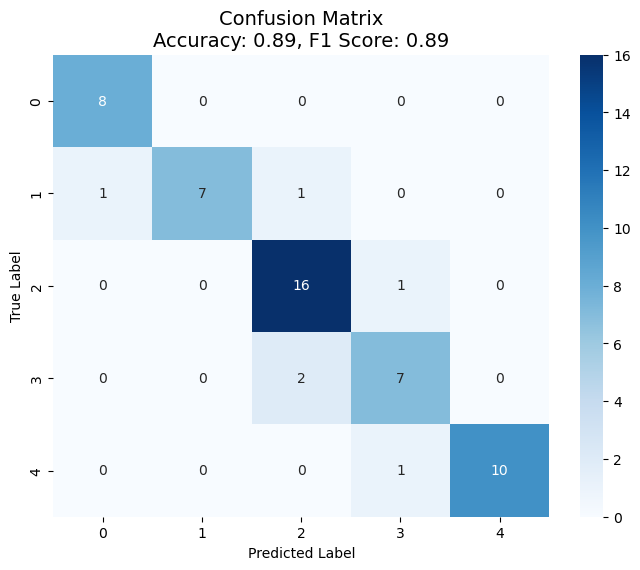

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Change to 'macro' or 'micro' as needed

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add accuracy and F1 score in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}', fontsize=14)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [59]:
from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")

In [60]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [61]:
X_train_encode = roberta_encode(X_train, tokenizer)
X_val_encode = roberta_encode(X_val, tokenizer)
X_test_encode = roberta_encode(X_test, tokenizer)


In [62]:
MAX_LEN = len(val_encodings['input_ids'][0])

In [66]:
def build_model(n_categories):
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

    # Import RoBERTa model from HuggingFace
    #roberta_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5, cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
    roberta_model = TFRobertaModel.from_pretrained('roberta-base', num_labels=5, cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
    x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]

    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [67]:
model = build_model(5)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 220)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 220)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 220)]                0         []                            
 )                                                                                                
                                                                                            

In [68]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [58]:
history = model.fit(X_train_encode,y_train,epochs=200,batch_size=16,
                        verbose=1,
                        validation_data=(X_val_encode, y_val),
                   callbacks=[early_stopping]
                   )



Epoch 1/200


2024-09-15 20:42:41.432830: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 165.00MiB (rounded to 173015040)requested by op gradient_tape/model_3/dense_6/MatMul/MatMul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-09-15 20:42:41.433036: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-09-15 20:42:41.433096: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 185, Chunks in use: 184. 46.2KiB allocated for chunks. 46.0KiB in use in bin. 949B client-requested in use in bin.
2024-09-15 20:42:41.433130: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 376B client-requested in use in

KeyboardInterrupt: 

# Model

In [31]:
X_train, X_test, y_train, y_test = train_test_split(text_encoding, problem_type_list, test_size=0.2, random_state=42)

NameError: name 'text_encoding' is not defined

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load dataset (you can replace with your dataset)
#X, y = load_iris(return_X_y=True)

# Split into train and test sets


# Define MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Evaluate
print(f"Accuracy: {mlp.score(X_test, y_test)}")


Accuracy: 0.24074074074074073


In [20]:
y_pred = mlp.predict(X_test)

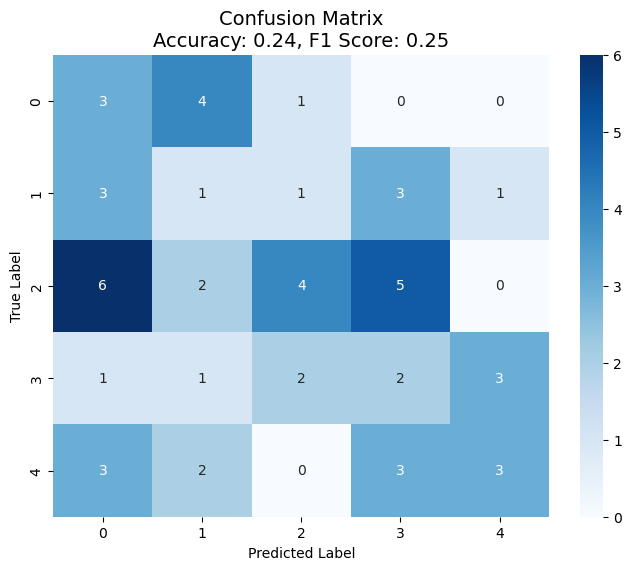

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Change to 'macro' or 'micro' as needed

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add accuracy and F1 score in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}', fontsize=14)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



# Define MLP model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # For multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), verbose = 1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

2024-09-15 16:41:17.750592: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 16:41:17.766074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 16:41:17.784914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 16:41:17.790954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 16:41:17.805933: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/300


I0000 00:00:1726432900.789085  122483 service.cc:146] XLA service 0x2aafd4004290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726432900.789112  122483 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726432900.789116  122483 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726432900.789119  122483 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726432900.789122  122483 service.cc:154]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726432900.789125  122483 service.cc:154]   StreamExecutor device (4): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726432900.789127  122483 service.cc:154]   StreamExecutor device (5): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1726432900.7891

1/7 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.3125 - loss: 58026.4922

I0000 00:00:1726432906.974381  122483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.2725 - loss: 54465.2500 - val_accuracy: 0.4259 - val_loss: 26373.5137
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3126 - loss: 28322.9414 - val_accuracy: 0.3519 - val_loss: 22291.7754
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3029 - loss: 23140.4727 - val_accuracy: 0.4630 - val_loss: 10753.6494
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2996 - loss: 16298.4902 - val_accuracy: 0.2778 - val_loss: 11486.4023
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3438 - loss: 12192.5918 - val_accuracy: 0.4259 - val_loss: 7276.0522
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2687 - loss: 8428.3330 - val_accuracy: 0.5185 - val_loss: 7021.7334
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3731 - loss: 8107.0386 - val_accuracy: 0.1852 - val_loss: 7452.0938
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3404 - loss: 6166.2

In [25]:
y_pred = np.argmax(model.predict(X_test),axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


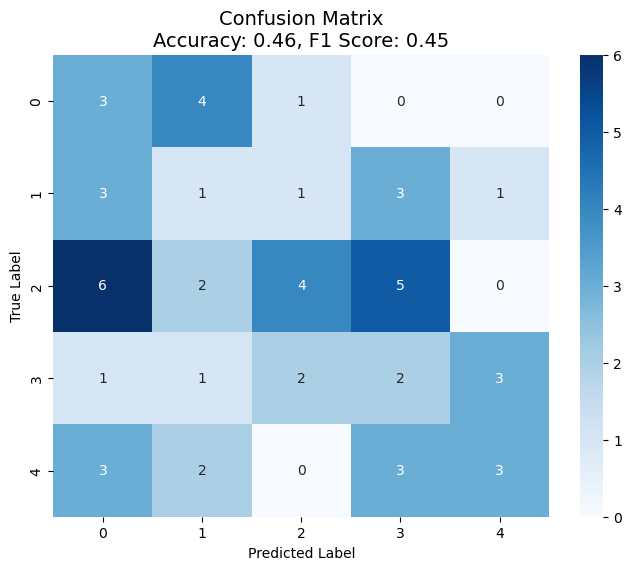

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_pred and y_test are your predicted and true labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Change to 'macro' or 'micro' as needed

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add accuracy and F1 score in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}', fontsize=14)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [89]:
topic = ['algebra__linear_1d', 'algebra__linear_1d_composed', 'algebra__linear_2d', 'algebra__linear_2d_composed', \
         'algebra__polynomial_roots', 'algebra__polynomial_roots_composed', \
         'algebra__sequence_next_term', 'algebra__sequence_nth_term', \
         'arithmetic__add_or_sub', 'arithmetic__add_or_sub_in_base', 'arithmetic__add_sub_multiple', 'arithmetic__div', \
         'arithmetic__mixed', 'arithmetic__mul', 'arithmetic__mul_div_multiple', 'arithmetic__nearest_integer_root', 'arithmetic__simplify_surd', \
         'calculus__differentiate', 'calculus__differentiate_composed', \
         'comparison__closest', 'comparison__closest_composed', 'comparison__kth_biggest', 'comparison__kth_biggest_composed', \
         'comparison__pair', 'comparison__pair_composed', 'comparison__sort', 'comparison__sort_composed', \
         'measurement__conversion', 'measurement__time', \
         'numbers__base_conversion', 'numbers__div_remainder', 'numbers__div_remainder_composed', 'numbers__gcd', 'numbers__gcd_composed',\
         'numbers__is_factor', 'numbers__is_factor_composed', 'numbers__is_prime', 'numbers__is_prime_composed', 'numbers__lcm', \
         'numbers__lcm_composed', 'numbers__list_prime_factors', 'numbers__list_prime_factors_composed', 'numbers__place_value', \
         'numbers__place_value_composed', 'numbers__round_number', 'numbers__round_number_composed',\
         'polynomials__add', 'polynomials__coefficient_named', 'polynomials__collect', 'polynomials__compose', 'polynomials__evaluate',\
         'polynomials__evaluate_composed', 'polynomials__expand', 'polynomials__simplify_power', 'probability__swr_p_level_set',\
         'probability__swr_p_sequence']

In [111]:
from datasets import load_dataset
dataset = load_dataset("deepmind/math_dataset", 'algebra__linear_2d_composed',  split=['train', 'test'], cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for deepmind/math_dataset contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/deepmind/math_dataset
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/1999998 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [112]:
train, test = dataset

In [113]:
train['question']

["b'Suppose -4*s - 124*v + 125*v = -9, -4 = -s + 2*v. Solve 3*q - s*n = -q, -n = 4*q + 12 for q.\\n'",
 "b'Suppose -x + 5*r = -26, 5*x = 4*r + 9 + 37. Suppose -5*i - u = 17, 2*u - 16 = 4*i + x. Let j = i + 6. Solve j*v + q - 8 = 0, 0 = -q + 2*q for v.\\n'",
 "b'Let v = 21 - 15. Let l = 1131 - 1129. Solve d + k = v, 2*k - 22 = -l*d - 2*k for d.\\n'",
 "b'Let a(x) = 2*x - 64. Let n be a(32). Let l be n - -4*(3 + -3 + 1). Solve 4*u + 6 = 2*u + k, 3*u - l*k = -19 for u.\\n'",
 "b'Let p = -196 - -198. Solve -p*c = -v + 3, -2*c + 6 = 3*v - 11 for v.\\n'",
 "b'Let h be 1/(-1) + (14 - 22). Let o be (-60)/h + 4/(-6). Solve -a - 13 = -o*a + 3*i, -4*a = -i - 9 for a.\\n'",
 "b'Let g = 555 + -553. Solve g*z + 3*p - 3 = 2*p, -p - 1 = -2*z for z.\\n'",
 "b'Suppose 1 = -10*c + 1. Solve -5*q + 0*z - 22 = -3*z, c = 2*q - 5*z + 24 for q.\\n'",
 "b'Let t(p) = -2*p**3 + 5*p**2 - 3*p + 2. Suppose 16*n - 8 = 12*n. Let o be t(n). Suppose o = -h + 25 - 9. Solve 3*m = g + h, -6*g = -g + 5 for m.\\n'",
 "b'Supp

In [93]:
train['answer']

["b'-2\\n'",
 "b'5\\n'",
 "b'-2\\n'",
 "b'2\\n'",
 "b'-3\\n'",
 "b'-1\\n'",
 "b'-3\\n'",
 "b'2\\n'",
 "b'2\\n'",
 "b'-4\\n'",
 "b'2\\n'",
 "b'3\\n'",
 "b'0\\n'",
 "b'-3\\n'",
 "b'-4\\n'",
 "b'4\\n'",
 "b'4\\n'",
 "b'2\\n'",
 "b'5\\n'",
 "b'0\\n'",
 "b'5\\n'",
 "b'4\\n'",
 "b'0\\n'",
 "b'-3\\n'",
 "b'-1\\n'",
 "b'5\\n'",
 "b'1\\n'",
 "b'-2\\n'",
 "b'3\\n'",
 "b'0\\n'",
 "b'2\\n'",
 "b'3\\n'",
 "b'1\\n'",
 "b'-3\\n'",
 "b'1\\n'",
 "b'-3\\n'",
 "b'-1\\n'",
 "b'-4\\n'",
 "b'-2\\n'",
 "b'-2\\n'",
 "b'1\\n'",
 "b'2\\n'",
 "b'0\\n'",
 "b'1\\n'",
 "b'-5\\n'",
 "b'0\\n'",
 "b'0\\n'",
 "b'3\\n'",
 "b'2\\n'",
 "b'0\\n'",
 "b'2\\n'",
 "b'0\\n'",
 "b'-4\\n'",
 "b'-2\\n'",
 "b'0\\n'",
 "b'-1\\n'",
 "b'-5\\n'",
 "b'2\\n'",
 "b'-5\\n'",
 "b'5\\n'",
 "b'-5\\n'",
 "b'-3\\n'",
 "b'5\\n'",
 "b'0\\n'",
 "b'4\\n'",
 "b'2\\n'",
 "b'5\\n'",
 "b'1\\n'",
 "b'4\\n'",
 "b'4\\n'",
 "b'4\\n'",
 "b'1\\n'",
 "b'-3\\n'",
 "b'-5\\n'",
 "b'-1\\n'",
 "b'4\\n'",
 "b'-2\\n'",
 "b'-5\\n'",
 "b'-4\\n'",
 "b'-3\\n'",
 "b'1\\n

In [50]:
dataset = load_dataset("allenai/math_qa", cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for allenai/math_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/allenai/math_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/29837 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2985 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4475 [00:00<?, ? examples/s]

In [57]:
train, test, valid = dataset['train'], dataset['test'], dataset['validation']

In [66]:
train

Dataset({
    features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
    num_rows: 29837
})

In [67]:
df = pd.DataFrame()
df['category'] = train['category']
df['text'] = train['Problem']

In [70]:
pd.set_option('display.max_colwidth', None)
df.head(50)

,category,text
0,gain,the banker ' s gain of a certain sum due 3 years hence at 10 % per annum is rs . 36 . what is the present worth ?
1,general,average age of students of an adult school is 40 years . 120 new students whose average age is 32 years joined the school . as a result the average age is decreased by 4 years . find the number of students of the school after joining of the new students .
2,general,sophia finished 2 / 3 of a book . she calculated that she finished 90 more pages than she has yet to read . how long is her book ?
3,gain,120 is what percent of 50 ?
4,other,there are 10 girls and 20 boys in a classroom . what is the ratio of girls to boys ?
5,gain,"an empty fuel tank with a capacity of 218 gallons was filled partially with fuel a and then to capacity with fuel b . fuel a contains 12 % ethanol by volume and fuel b contains 16 % ethanol by volume . if the full fuel tank contains 30 gallons of ethanol , how many gallons of fuel a were added ?"
6,gain,"an article is bought for rs . 823 and sold for rs . 1000 , find the gain percent ?"
7,physics,6 workers should finish a job in 8 days . after 3 days came 4 workers join them . how many days m do they need to finish the same job ?
8,gain,j is 25 % less than p and 20 % less than t . t is q % less than p . what is the value of q ?
9,general,"a student was asked to find 4 / 5 of a number . but the student divided the number by 4 / 5 , thus the student got 36 more than the correct answer . find the number ."


In [71]:
dataset = load_dataset("deepmind/math_dataset",  split=['train', 'test'], cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for deepmind/math_dataset contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/deepmind/math_dataset
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


ValueError: Config name is missing.
Please pick one among the available configs: ['algebra__linear_1d', 'algebra__linear_1d_composed', 'algebra__linear_2d', 'algebra__linear_2d_composed', 'algebra__polynomial_roots', 'algebra__polynomial_roots_composed', 'algebra__sequence_next_term', 'algebra__sequence_nth_term', 'arithmetic__add_or_sub', 'arithmetic__add_or_sub_in_base', 'arithmetic__add_sub_multiple', 'arithmetic__div', 'arithmetic__mixed', 'arithmetic__mul', 'arithmetic__mul_div_multiple', 'arithmetic__nearest_integer_root', 'arithmetic__simplify_surd', 'calculus__differentiate', 'calculus__differentiate_composed', 'comparison__closest', 'comparison__closest_composed', 'comparison__kth_biggest', 'comparison__kth_biggest_composed', 'comparison__pair', 'comparison__pair_composed', 'comparison__sort', 'comparison__sort_composed', 'measurement__conversion', 'measurement__time', 'numbers__base_conversion', 'numbers__div_remainder', 'numbers__div_remainder_composed', 'numbers__gcd', 'numbers__gcd_composed', 'numbers__is_factor', 'numbers__is_factor_composed', 'numbers__is_prime', 'numbers__is_prime_composed', 'numbers__lcm', 'numbers__lcm_composed', 'numbers__list_prime_factors', 'numbers__list_prime_factors_composed', 'numbers__place_value', 'numbers__place_value_composed', 'numbers__round_number', 'numbers__round_number_composed', 'polynomials__add', 'polynomials__coefficient_named', 'polynomials__collect', 'polynomials__compose', 'polynomials__evaluate', 'polynomials__evaluate_composed', 'polynomials__expand', 'polynomials__simplify_power', 'probability__swr_p_level_set', 'probability__swr_p_sequence']
Example of usage:
	`load_dataset('math_dataset', 'algebra__linear_1d')`